## 高维线性回归

我们通过一个简单的例子来演示权重衰减。

In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

首先，我们[**像以前一样生成一些数据**]，生成公式如下：

(**$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$**)

我们选择标签是关于输入的线性函数。
标签同时被均值为0，标准差为0.01高斯噪声破坏。
为了使过拟合的效果更加明显，我们可以将问题的维数增加到$d = 200$，
并使用一个只包含20个样本的小训练集。

In [2]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05

In [4]:
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

## 从零开始实现

下面我们将从头开始实现权重衰减，只需将$L_2$的平方惩罚添加到原始目标函数中。

### [**初始化模型参数**]

首先，我们将定义一个函数来随机初始化模型参数。

In [30]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

### (**定义$L_2$范数惩罚**)

实现这一惩罚最方便的方法是对所有项求平方后并将它们求和。

In [31]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

### [**定义训练代码实现**]

下面的代码将模型拟合训练数据集，并在测试数据集上进行评估。
从 :numref:`chap_linear`以来，线性网络和平方损失没有变化，
所以我们通过`d2l.linreg`和`d2l.squared_loss`导入它们。
唯一的变化是损失现在包括了惩罚项。

In [29]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

### [**忽略正则化直接训练**]

我们现在用`lambd = 0`禁用权重衰减后运行这个代码。
注意，这里训练误差有了减少，但测试误差没有减少，
这意味着出现了严重的过拟合。

w的L2范数是： 13.399700164794922


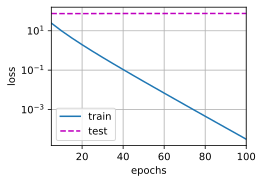

In [25]:
train(lambd=0)

### [**使用权重衰减**]

下面，我们使用权重衰减来运行代码。
注意，在这里训练误差增大，但测试误差减小。
这正是我们期望从正则化中得到的效果。

w的L2范数是： 0.4003070592880249


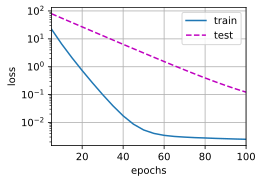

In [26]:
train(lambd=3)

## [**简洁实现**]

由于权重衰减在神经网络优化中很常用，
深度学习框架为了便于我们使用权重衰减，
将权重衰减集成到优化算法中，以便与任何损失函数结合使用。
此外，这种集成还有计算上的好处，
允许在不增加任何额外的计算开销的情况下向算法中添加权重衰减。
由于更新的权重衰减部分仅依赖于每个参数的当前值，
因此优化器必须至少接触每个参数一次。

在下面的代码中，我们在实例化优化器时直接通过`weight_decay`指定weight decay超参数。
默认情况下，PyTorch同时衰减权重和偏移。
这里我们只为权重设置了`weight_decay`，所以偏置参数$b$不会衰减。

In [42]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

[**这些图看起来和我们从零开始实现权重衰减时的图相同**]。
然而，它们运行得更快，更容易实现。
对于更复杂的问题，这一好处将变得更加明显。

w的L2范数： 14.189116477966309


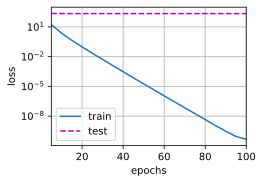

In [43]:
train_concise(0)

w的L2范数： 0.39125555753707886


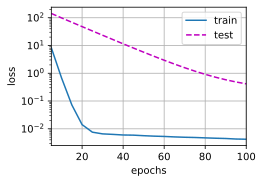

In [44]:
train_concise(3)

到目前为止，我们只接触到一个简单线性函数的概念。
此外，由什么构成一个简单的非线性函数可能是一个更复杂的问题。
例如，[再生核希尔伯特空间（RKHS）](https://en.wikipedia.org/wiki/Reproducing_kernel_Hilbert_space)
允许在非线性环境中应用为线性函数引入的工具。
不幸的是，基于RKHS的算法往往难以应用到大型、高维的数据。
在这本书中，我们将默认使用简单的启发式方法，即在深层网络的所有层上应用权重衰减。

## 小结

* 正则化是处理过拟合的常用方法：在训练集的损失函数中加入惩罚项，以降低学习到的模型的复杂度。
* 保持模型简单的一个特别的选择是使用$L_2$惩罚的权重衰减。这会导致学习算法更新步骤中的权重衰减。
* 权重衰减功能在深度学习框架的优化器中提供。
* 在同一训练代码实现中，不同的参数集可以有不同的更新行为。